### Домашнее задание №5 ###
<ol>
<li>Ответьте на вопросы:
В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной филтьтрации?

Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы

<li>Прочитайте статью про поиск на hh.ru https://habr.com/ru/company/hh/blog/347276/ Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен?

<li>На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html). В работе Data Scientist'а важную часть заниет research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:

<ol>
<li>Какой датасет используют авторы?
<li>Что используют в качестве признаков?
<li>С какими моделями сравнивают LightFM? Опишите их основные идеи кратко
</ol></ol>

## Практическая часть ##

### 1. Модуль SRC

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os,sys


module_path = os.path.abspath(os.path.join(os.pardir))
print(f'module path = {module_path}')
if module_path not in sys.path:
    sys.path.append(module_path)

print(f'module path = {sys.path}')

import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix, coo_matrix    
from src.metrics import precision_at_k, recall_at_k
from src.recommenders import MainRecommender
from src.utils import prefilter_items
import lightfm.evaluation
import seaborn as sns



module path = C:\Users\User\edu\git_works
module path = ['C:\\Users\\User\\edu\\git_works\\rec_system', 'C:\\Users\\User\\anaconda3\\python38.zip', 'C:\\Users\\User\\anaconda3\\DLLs', 'C:\\Users\\User\\anaconda3\\lib', 'C:\\Users\\User\\anaconda3', '', 'C:\\Users\\User\\anaconda3\\lib\\site-packages', 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\locket-0.2.1-py3.8.egg', 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\User\\.ipython', 'C:\\Users\\User\\edu\\git_works']


In [4]:
data = pd.read_csv('../rec_data/transaction_data.csv')
item_features = pd.read_csv('../rec_data/product.csv')
user_features = pd.read_csv('../rec_data/hh_demographic.csv')

In [5]:
data.describe().style.set_precision(0)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
count,2595732,2595732,2595732,2595732,2595732,2595732,2595732,2595732,2595732,2595732,2595732,2595732
mean,1272,34026199139,389,2891435,100,3,3143,-1,1562,56,-0,-0
std,726,4711649038,190,3837404,1153,4,8937,1,400,27,0,0
min,1,26984851472,1,25671,0,0,1,-180,0,1,-56,-8
25%,656,30408046256,229,917459,1,1,330,-1,1308,33,0,0
50%,1272,32760806548,390,1028816,1,2,372,-0,1613,56,0,0
75%,1913,40126853628,553,1133018,1,3,422,0,1843,80,0,0
max,2500,42305362535,711,18316298,89638,840,34280,4,2359,102,0,0


In [11]:
data.info(),'--------------------', data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   household_key      int64  
 1   BASKET_ID          int64  
 2   DAY                int64  
 3   PRODUCT_ID         int64  
 4   QUANTITY           int64  
 5   SALES_VALUE        float64
 6   STORE_ID           int64  
 7   RETAIL_DISC        float64
 8   TRANS_TIME         int64  
 9   WEEK_NO            int64  
 10  COUPON_DISC        float64
 11  COUPON_MATCH_DISC  float64
dtypes: float64(4), int64(8)
memory usage: 237.6 MB


(None, '--------------------', (2595732, 12))

In [12]:
item_features.info(),'--------------------', item_features.describe(),'--------------------',  item_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PRODUCT_ID            92353 non-null  int64 
 1   MANUFACTURER          92353 non-null  int64 
 2   DEPARTMENT            92353 non-null  object
 3   BRAND                 92353 non-null  object
 4   COMMODITY_DESC        92353 non-null  object
 5   SUB_COMMODITY_DESC    92353 non-null  object
 6   CURR_SIZE_OF_PRODUCT  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


(None,
 '--------------------',
          PRODUCT_ID  MANUFACTURER
 count  9.235300e+04   92353.00000
 mean   5.328353e+06    1739.22833
 std    5.359937e+06    1818.26957
 min    2.567100e+04       1.00000
 25%    9.706280e+05     328.00000
 50%    1.621091e+06    1094.00000
 75%    9.704770e+06    2264.00000
 max    1.831630e+07    6477.00000,
 '--------------------',
 (92353, 7))

In [13]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PRODUCT_ID            92353 non-null  int64 
 1   MANUFACTURER          92353 non-null  int64 
 2   DEPARTMENT            92353 non-null  object
 3   BRAND                 92353 non-null  object
 4   COMMODITY_DESC        92353 non-null  object
 5   SUB_COMMODITY_DESC    92353 non-null  object
 6   CURR_SIZE_OF_PRODUCT  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


In [14]:
user_features.describe()

,household_key
count,801.000000
mean,1235.176030
std,736.804647
min,1.000000
25%,596.000000
50%,1218.000000
75%,1914.000000
max,2499.000000


In [15]:
user_features.shape

(801, 8)

In [16]:
#переименовываем заголовки столбцов, для удобства работы, все строчные
item_features.columns = [col.lower() for col in item_features.columns]
data.columns = [col.lower() for col in data.columns]

# переименовываем заголовки для user и item
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)
data.rename(columns={'household_key': 'user_id'}, inplace=True)
data.rename(columns={'product_id': 'item_id'}, inplace=True)

In [17]:
%%time
data = prefilter_items(data)

Wall time: 3.23 s


In [18]:
data

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19
12,1364,26984896261,1,999999,1,2.99,31742,-0.40,1520,1,0.0,0.0,2.99
13,1364,26984896261,1,999999,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595717,2225,42302712298,711,999999,1,4.89,446,0.00,1754,102,0.0,0.0,4.89
2595728,1598,42305362535,711,999999,1,8.89,3228,0.00,1520,102,0.0,0.0,8.89
2595729,1598,42305362535,711,999999,1,6.99,3228,0.00,1520,102,0.0,0.0,6.99
2595730,1598,42305362535,711,999999,1,4.50,3228,-0.49,1520,102,0.0,0.0,4.50


In [19]:
%%time
model = MainRecommender(data)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 6.78 s


In [20]:
user = 2000

In [21]:
user_purchases = data[(data['user_id'] == user)&(data['item_id'] != 999999)]['item_id']
user_purchases = np.array(user_purchases)
len(user_purchases)

58

In [22]:
user_purchases

array([  844179,  1029743,  8090521,   926905,   967144,  1138677,
        8090509,  1016800,   839656,  8090509,  8090537,   826842,
         967144,   926905,  8090521,  1050851,   973002,  5569172,
         828055,  1016800,  1029743,  1057113,  1029743,   926905,
         998119,  8019921,   823266,  8090513,  8090521,  8090537,
        8090513,  8090537,   930385,  9655696,  1046555,  1050851,
        1060292,   835619,   830935,   843689,  1007136,  1035691,
        9707240,   909249,  1009719,   850102,  1015785,   916122,
        1000753,  1050851,  1070702,  9835223,  1068719,   842769,
         947146,  9296856,  5569172, 13115666], dtype=int64)

In [23]:
items = model.get_similar_items_recommendation(user, N=len(user_purchases))
items[:5]

[850102, 8090509, 12301405, 972931, 1016800]

### 2. Работа с признаками

У этого алогритма есть множество параметров (item/user_alpha, loss, no_components).  
Проведите эксперименты аналогично дз 3 (подберите гипперпараметры каким удобно способои и постройте графики)  
На выходе необходимо получить pr@5 на валидации (последние 3 недели) > 17%  

У Вас, скорее всего, возникнет проблема со временем обучения. Почему они возникает?    

Попробуйте запустить алгоритм вообще без фичей или используйте только признаки с небольшим числом уникальных категорий. (item_features['commodity_desc'].unique() - 300 уникальных категорий - это очень много)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1079613 entries, 7 to 2595731
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   user_id            1079613 non-null  int64  
 1   basket_id          1079613 non-null  int64  
 2   day                1079613 non-null  int64  
 3   item_id            1079613 non-null  int64  
 4   quantity           1079613 non-null  int64  
 5   sales_value        1079613 non-null  float64
 6   store_id           1079613 non-null  int64  
 7   retail_disc        1079613 non-null  float64
 8   trans_time         1079613 non-null  int64  
 9   week_no            1079613 non-null  int64  
 10  coupon_disc        1079613 non-null  float64
 11  coupon_match_disc  1079613 non-null  float64
 12  price              1079613 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 115.3 MB


In [25]:
data.describe().style.set_precision(1)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
count,1079613.0,1079613.0,1079613.0,1079613.0,1079613.0,1079613.0,1079613.0,1079613.0,1079613.0,1079613.0,1079613.0,1079613.0,1079613.0
mean,1276.0,34088317957.8,391.0,2228258.3,1.1,4.7,3332.8,-0.7,1563.5,56.5,-0.0,-0.0,4.1
std,721.7,4742827639.5,190.7,3050786.1,0.5,3.8,9210.0,1.7,395.7,27.2,0.2,0.0,2.9
min,1.0,26984851516.0,1.0,818981.0,0.0,2.0,1.0,-180.0,0.0,1.0,-55.9,-2.7,2.0
25%,671.0,30503918029.0,230.0,983584.0,1.0,2.7,333.0,-0.8,1309.0,34.0,0.0,0.0,2.5
50%,1274.0,32835682876.0,394.0,999999.0,1.0,3.5,372.0,0.0,1614.0,57.0,0.0,0.0,3.2
75%,1907.0,40186351956.0,558.0,1088771.0,1.0,5.0,424.0,0.0,1843.0,80.0,0.0,0.0,4.4
max,2500.0,42305362535.0,711.0,18119016.0,40.0,324.8,34280.0,4.0,2359.0,102.0,0.0,0.0,50.0


In [26]:
data.nunique()

user_id                2500
basket_id            208830
day                     710
item_id                5001
quantity                 30
sales_value            3414
store_id                522
retail_disc            2340
trans_time             1440
week_no                 102
coupon_disc             218
coupon_match_disc        30
price                  5039
dtype: int64

In [27]:
for col in data.columns:
    print(col, ':', data[col].unique(), '\n')

user_id : [2375 1364 1172 ... 1984 2259 2325] 

basket_id : [26984851516 26984896261 26985025264 ... 42302712189 42302712298
 42305362535] 

day : [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 203 202 204 205 206 207 208 210 211 2

In [28]:
item_features.nunique()

item_id                 92353
manufacturer             6476
department                 44
brand                       2
commodity_desc            308
sub_commodity_desc       2383
curr_size_of_product     4345
dtype: int64

In [29]:
for col in item_features.columns:
    print(col, ':', item_features[col].unique(), '\n')

item_id : [   25671    26081    26093 ... 18293696 18294080 18316298] 

manufacturer : [   2   69   16 ... 2748 4868 2227] 

department : ['GROCERY' 'MISC. TRANS.' 'PASTRY' 'DRUG GM' 'MEAT-PCKGD' 'SEAFOOD-PCKGD'
 'PRODUCE' 'NUTRITION' 'DELI' 'COSMETICS' 'MEAT' 'FLORAL'
 'TRAVEL & LEISUR' 'SEAFOOD' 'MISC SALES TRAN' 'SALAD BAR' 'KIOSK-GAS'
 'ELECT &PLUMBING' 'GRO BAKERY' 'GM MERCH EXP' 'FROZEN GROCERY'
 'COUP/STR & MFG' 'SPIRITS' 'GARDEN CENTER' 'TOYS' 'CHARITABLE CONT'
 'RESTAURANT' 'RX' 'PROD-WHS SALES' 'MEAT-WHSE' 'DAIRY DELI' 'CHEF SHOPPE'
 'HBC' 'DELI/SNACK BAR' 'PORK' 'AUTOMOTIVE' 'VIDEO RENTAL' ' '
 'CNTRL/STORE SUP' 'HOUSEWARES' 'POSTAL CENTER' 'PHOTO' 'VIDEO'
 'PHARMACY SUPPLY'] 

brand : ['National' 'Private'] 

commodity_desc : ['FRZN ICE' 'NO COMMODITY DESCRIPTION' 'BREAD' 'FRUIT - SHELF STABLE'
 'COOKIES/CONES' 'SPICES & EXTRACTS' 'VITAMINS' 'BREAKFAST SWEETS'
 'PNT BTR/JELLY/JAMS' 'ICE CREAM/MILK/SHERBTS' 'MAGAZINE' 'AIR CARE'
 'CHEESE' 'SHORTENING/OIL' 'COFFEE' 'DIETARY A

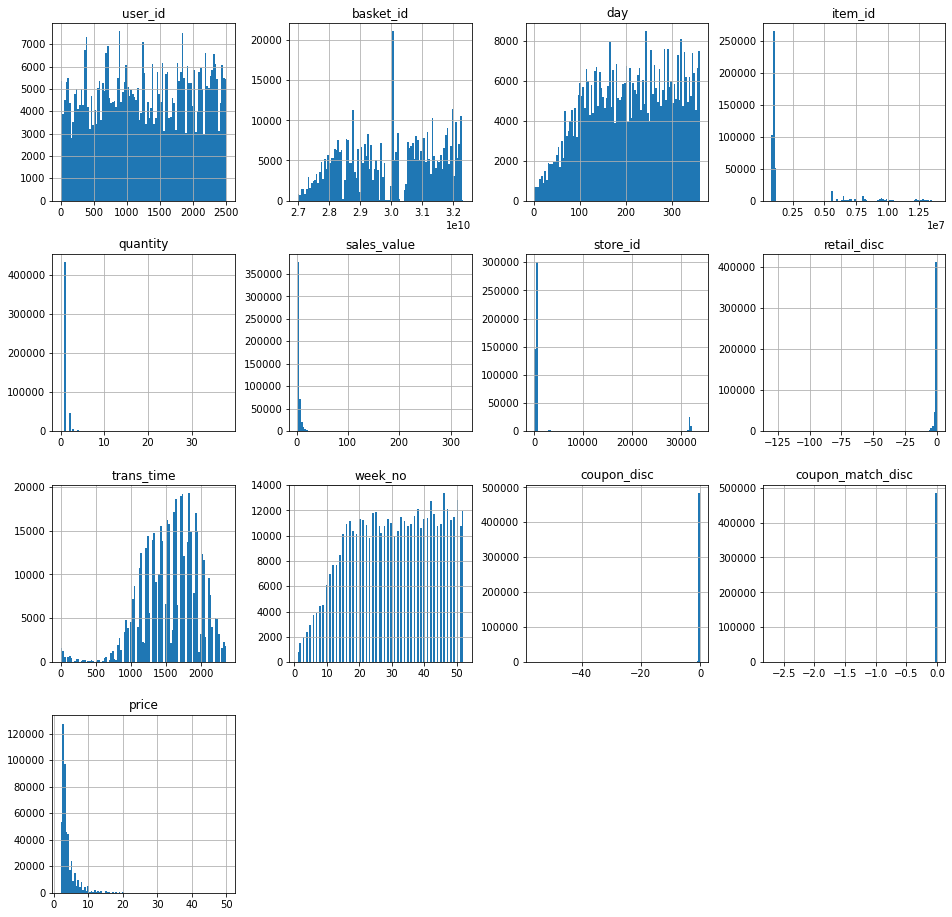

In [30]:
#Первый год
data[data['week_no']<=52].hist(figsize=(16,16), bins=100, grid=True);

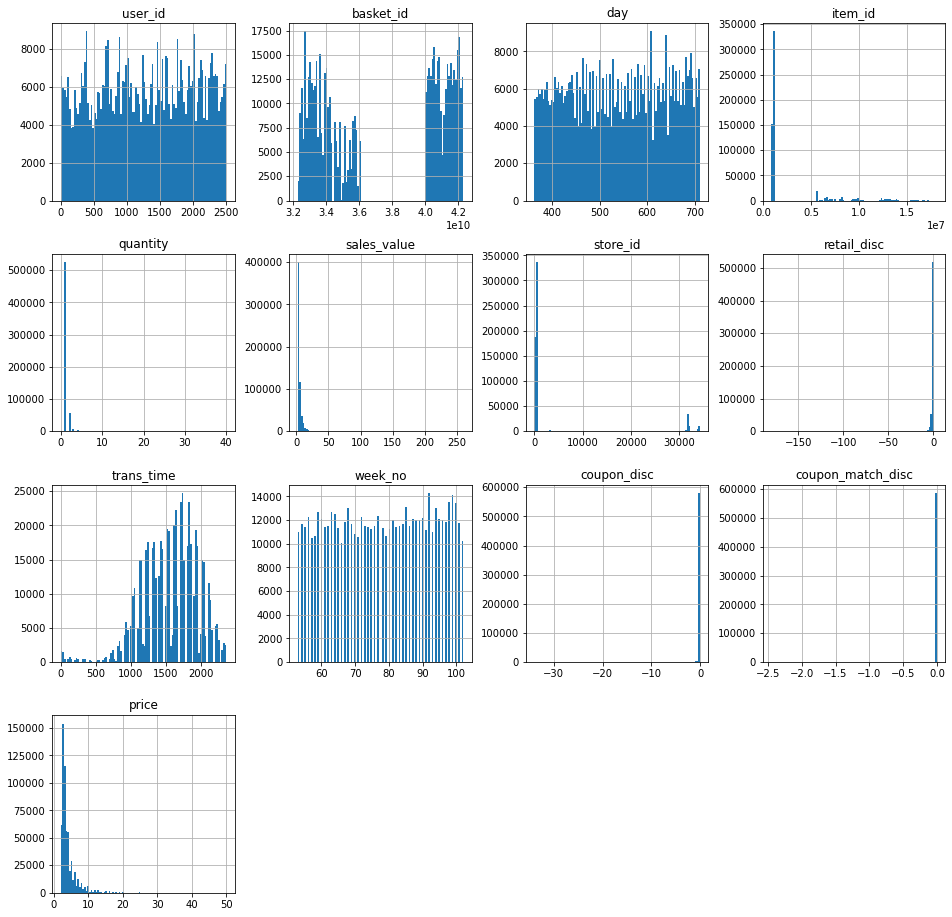

In [31]:
#второй год
data[data['week_no']>52].hist(figsize=(16,16), bins=100, grid=True);

<AxesSubplot:xlabel='basket_id', ylabel='Density'>

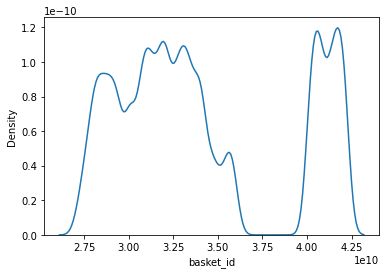

In [32]:
list = data.columns
sns.kdeplot(data=data[list[1]])

<AxesSubplot:xlabel='basket_id', ylabel='Density'>

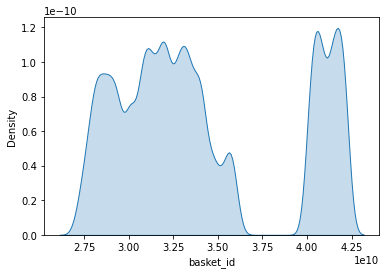

In [37]:
sns.kdeplot(data=data[list[1]],fill=True)


<AxesSubplot:xlabel='day', ylabel='Density'>

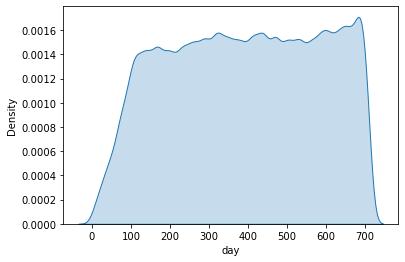

In [38]:
sns.kdeplot(data=data[list[2]],fill=True)

<AxesSubplot:xlabel='week_no', ylabel='Density'>

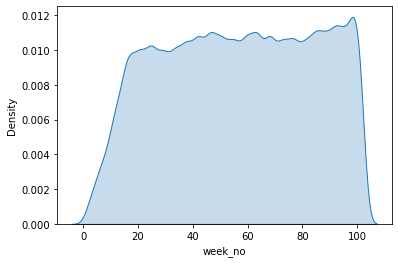

In [39]:
sns.kdeplot(data=data['week_no'],fill=True)

<AxesSubplot:xlabel='price', ylabel='Density'>

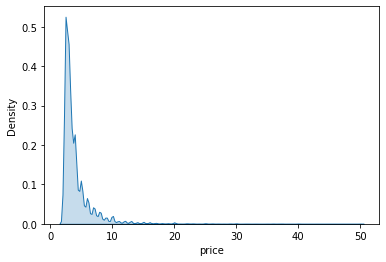

In [36]:
sns.kdeplot(data=data['price'],fill=True)

In [ ]:
sns.kdeplot(data=data['trans_time'],fill=True)

In [ ]:
data.describe().style.set_precision(0)

Больше всего покупок совершалось в районе 18-43

Популярный магазин № 424

Виден рост кол-во покупок в начале, далее рост стабилизируется.
больше всего покупок на 558 день,это 193 день второго года от начала отсчета. Если считать, что отсчет велся от 1 января, то 193 день это 11 июля. Странно что 11 июля совершенно больше всего покупок, обычно больше всего покупок совершается в дни распродаж в конце года, то можно считать что отсчет в датасете велся не с 1 января и привязываться к датам не стоит.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
sns.histplot(data=data['item_id'])

In [ ]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")

sns.histplot(data=data['quantity'])

**3.** LightFM 

In [ ]:
data = pd.read_csv('../input/hw5-data/transaction_data.csv')
item_features = pd.read_csv('../input/hw5-data/product.csv')
user_features = pd.read_csv('../input/hw5-data/hh_demographic.csv')

In [ ]:
data.shape